In [ ]:
#| default_exp preprocessing

In [2]:
from allos.readers_tests import *
from allos.preprocessing import subset_common_cells, transfer_obs
import pandas as pd
df = pd.read_csv('e18.mouse.clusters.csv')
df['barcode'] = df.index.str.split('_').str[1]


mouse_data_str_1 = download_test_data()
print("Test data downloaded successfully")


mouse_data_str_2 = download_test_data("https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3748nnn/GSM3748089/suppl/GSM3748089%5F951c.isoforms.matrix.txt.gz")
print("Test data downloaded successfully")


mouse_1 = read_sicelore_isomatrix(file_path=mouse_data_str_1)
mouse_2 = read_sicelore_isomatrix(file_path=mouse_data_str_2)

combined_mouse_data = iso_concat([mouse_1, mouse_2], batch_type='numeric')


combined_mouse_data.obs_names_make_unique()
# Step 1: Remove any duplicate barcodes in the DataFrame
df_unique = df.drop_duplicates(subset='barcode')

# Step 2: Filter the DataFrame to include only the barcodes present in the AnnData object
df_filtered = df_unique[df_unique['barcode'].isin(combined_mouse_data.obs_names)]

# Step 3: Set the index of the filtered DataFrame to 'barcode' to make the merge easier
df_filtered.set_index('barcode', inplace=True)

# Step 4: Create a DataFrame from the obs DataFrame of the AnnData object to ensure the same index
obs_df = combined_mouse_data.obs.copy()

# Step 5: Initialize a new column 'cell_type' with NaN values in the obs DataFrame
obs_df['cell_type'] = pd.NA

# Step 6: Update the 'cell_type' column with values from the filtered DataFrame where indices match
obs_df.update(df_filtered['illumina.ident'].rename('cell_type'))

# Step 7: Ensure the index is unique and assign the updated DataFrame back to the obs attribute of the AnnData object
if obs_df.index.is_unique:
    combined_mouse_data.obs = obs_df
else:
    raise ValueError("The index of the obs DataFrame is not unique.")

# Now, the 'cell_type' column should be added to the obs DataFrame of your AnnData object
combined_mouse_data = combined_mouse_data[~combined_mouse_data.obs['cell_type'].isna()]
combined_mouse_data.var.index

Starting download of test data from https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3748nnn/GSM3748087/suppl/GSM3748087%5F190c.isoforms.matrix.txt.gz
File downloaded successfully
File extracted successfully
Test data downloaded successfully
Starting download of test data from https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3748nnn/GSM3748089/suppl/GSM3748089%5F951c.isoforms.matrix.txt.gz
File downloaded successfully
File extracted successfully
Test data downloaded successfully


/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Index(['ENSMUST00000156717.1', 'ENSMUST00000212520.1', 'ENSMUST00000025798.12',
       'ENSMUST00000231280.1', 'ENSMUST00000039286.4', 'ENSMUST00000144552.7',
       'ENSMUST00000112304.8', 'ENSMUST00000162041.7', 'ENSMUST00000053506.6',
       'ENSMUST00000028207.12',
       ...
       'ENSMUST00000141019.1', 'ENSMUST00000213971.1', 'ENSMUST00000047275.7',
       'ENSMUST00000019994.13', 'ENSMUST00000147414.1', 'ENSMUST00000127375.1',
       'ENSMUST00000125687.1', 'ENSMUST00000139277.7', 'ENSMUST00000044234.13',
       'ENSMUST00000198403.1'],
      dtype='object', name='transcriptId', length=31986)

In [4]:
#| export
import scanpy as sc


def subset_common_cells( dataset1:sc.AnnData,  # First dataset to be subsetted.
                        dataset2:sc.AnnData   # Second dataset to compare with.
                        ) -> sc.AnnData:  # Subset of `dataset1` containing only cells also found in `dataset2`.
    
    "Subset `dataset1` to only include cells that are also present in `dataset2`."
    # Find common cells by intersecting the cell identifiers of both datasets
    common_cells = dataset1.obs_names.intersection(dataset2.obs_names)
    
    # Explicitly subset dataset1 to only include these common cells
    subset_dataset1 = dataset1[common_cells, :].copy()
    
    return subset_dataset1

In [5]:
#| export 

import pandas as pd
import anndata as ad

#| export
def transfer_obs(dataset1: ad.AnnData,  # Source AnnData object with .obs metadata to transfer.
                 dataset2: ad.AnnData   # Target AnnData object to receive .obs metadata.
                 ) -> ad.AnnData:       # The modified `dataset2` with .obs from `dataset1` transferred.
    "Transfer `.obs` metadata from `dataset1` to `dataset2` one by one, while preserving the `.var` DataFrame of `dataset2`."
    
    # Ensure dataset2's .var is preserved without altering its contents
    var_dataset2 = dataset2.var.copy()
    
    # Clear current .obs in dataset2 to ensure it only contains metadata from dataset1
    dataset2.obs = pd.DataFrame(index=dataset2.obs.index)
    
    # Loop through each column in dataset1.obs and transfer it to dataset2.obs
    for column_name in dataset1.obs.columns:
        # Transfer each column individually
        dataset2.obs[column_name] = dataset1.obs[column_name].copy()

    # Reapply the saved .var to dataset2 to ensure it's preserved
    dataset2.var = var_dataset2

    return dataset2

In [44]:
#| export
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix

def get_sot_gene_matrix(adata):
    """
    Construct a gene-level count matrix from transcript-level data.
    
    Parameters
    ----------
    adata : AnnData
        Input AnnData with transcript-level counts. Must have a column `geneId`
        in `adata.var` containing the gene ID for each transcript.
    
    Returns
    -------
    AnnData
        A new AnnData object where columns (var) represent unique genes, 
        and values are aggregated transcript counts.
    """
    # gene_ids must be something like adata.var['geneId']
    gene_ids = adata.var['geneId'].values
    
    # Find the unique gene IDs and map each transcript to one of these genes
    unique_gene_ids, inverse = np.unique(gene_ids, return_inverse=True)
    
    # Convert adata.X to a COO matrix (cheap if already sparse)
    X_coo = coo_matrix(adata.X)

    
    # Re-map the column indices: each old column index -> new gene index
    new_row = X_coo.row
    new_col = inverse[X_coo.col]
    new_data = X_coo.data
    
    # Build the new sparse matrix
    # (COO duplicates are summed when converting to CSR/CSC)
    new_coo = coo_matrix(
        (new_data, (new_row, new_col)),
        shape=(adata.n_obs, len(unique_gene_ids))
    )
    new_X = new_coo.tocsr()  # or .tocsc(), whichever you prefer
    
    # Build a new AnnData object at gene level
    adata_gene_level = sc.AnnData(
        X=new_X,
        obs=adata.obs.copy(),
        var=pd.DataFrame(index=unique_gene_ids)
    )

    adata_gene_level.var.index.names = ['geneId']

    
    return adata_gene_level


In [45]:
gene_adata = get_sot_gene_matrix(combined_mouse_data)

In [46]:
gene_adata.var

""
geneId
0610009O20Rik
1110020A21Rik
1600014C23Rik
1700028P14Rik
1700086O06Rik
...
mt-Nd3
mt-Nd4
mt-Nd4l


In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def gene_wise_correlation(
    adata_1,
    adata_2,
    label_1="Short_Reads",
    label_2="Long_Reads",
    density_hist=True
):
    """
    Generalized function that uses your existing get_sot_gene_matrix(...) 
    to produce gene-level counts for each dataset, merges them, 
    and plots a log correlation.

    Parameters
    ----------
    adata_1 : AnnData
        First AnnData, presumably transcript-level. Must have a 'geneId' column in .var.
    adata_2 : AnnData
        Second AnnData, presumably transcript-level. Must have a 'geneId' column in .var.
    label_1 : str
        Label for the first dataset in the merged DataFrame and on plots.
    label_2 : str
        Label for the second dataset in the merged DataFrame and on plots.
    density_hist : bool
        If True, display a scatter + marginal histograms. If False, scatter only.

    Returns
    -------
    merged_df : pd.DataFrame
        DataFrame with columns:
          ['gene_name', label_1, label_2, 'log_x', 'log_y'],
        plus any intermediate columns used for plotting.
    """
    # 1) Convert each AnnData to a gene-level matrix using your get_sot_gene_matrix
    if 'transcriptId' in adata_1.var.index.name:  
        adata_1_gene = get_sot_gene_matrix(adata_1)
    else:
        adata_1_gene = adata_1

    if 'transcriptId' in adata_2.var.index.name:
        print("creating gene matrix")
        adata_2_gene = get_sot_gene_matrix(adata_2)
    else:
        adata_2_gene = adata_2
        

    # 2) Sum across rows (cells) to get total counts per gene in each
    counts_1 = np.array(adata_1_gene.X.sum(axis=0)).flatten()
    gene_names_1 = adata_1_gene.var_names
    print(gene_names_1)

    counts_2 = np.array(adata_2_gene.X.sum(axis=0)).flatten()
    gene_names_2 = adata_2_gene.var_names
    print(gene_names_2)

    # 3) Build DataFrames and merge on gene name
    df_1 = pd.DataFrame({label_1: counts_1, "gene_name": gene_names_1})
    df_2 = pd.DataFrame({label_2: counts_2, "gene_name": gene_names_2})
    merged_df = pd.merge(df_1, df_2, on="gene_name", how="inner")

    # 4) Compute log1p, correlation, and plot
    merged_df["log_x"] = np.log1p(merged_df[label_1])
    merged_df["log_y"] = np.log1p(merged_df[label_2])

    corr, p_value = pearsonr(merged_df["log_x"], merged_df["log_y"])
    epsilon = 1e-16
    display_pval = epsilon if p_value < epsilon else p_value

    sns.set_theme(context="talk", style="whitegrid")

    if density_hist:
        # Joint plot with histograms on the margins
        g = sns.JointGrid(data=merged_df, x="log_x", y="log_y", height=8)
        g.plot_joint(sns.scatterplot, color="black", alpha=0.4, s=40)

        # Diagonal line y=x
        max_val = float(max(merged_df["log_x"].max(), merged_df["log_y"].max()))
        g.ax_joint.plot([0, max_val], [0, max_val], ls="--", color="red", lw=2)

        g.plot_marginals(sns.histplot, kde=True, bins=30, color="gray", alpha=0.7)

        # Title and annotation
        g.fig.suptitle(
            f"Gene-wise Correlation\n({label_1} vs {label_2})",
            fontsize=18, y=1.02
        )
        g.ax_joint.text(
            0.05, 0.95,
            f"r = {corr:.3f}, p < {display_pval:.2e}",
            transform=g.ax_joint.transAxes, 
            ha="left", va="top", fontsize=14,
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")
        )

        g.ax_joint.set_xlabel(f"log({label_1} + 1)", fontsize=14)
        g.ax_joint.set_ylabel(f"log({label_2} + 1)", fontsize=14)
        g.fig.tight_layout()
        plt.show()

    else:
        # Simple scatter
        plt.figure(figsize=(10, 8))
        sns.scatterplot(
            data=merged_df, x="log_x", y="log_y",
            color="black", alpha=0.4, s=40
        )
        max_val = float(max(merged_df["log_x"].max(), merged_df["log_y"].max()))
        plt.plot([0, max_val], [0, max_val], ls="--", color="red", lw=2)

        plt.title(f"Gene-wise Correlation\n({label_1} vs {label_2})", fontsize=18)
        plt.xlabel(f"log({label_1} + 1)", fontsize=14)
        plt.ylabel(f"log({label_2} + 1)", fontsize=14)

        plt.text(
            0.05 * max_val, 0.95 * max_val,
            f"r = {corr:.3f}, p < {display_pval:.2e}",
            ha="left", va="top", fontsize=14,
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")
        )

        plt.tight_layout()
        plt.show()

    return merged_df


In [84]:
if "transcriptId" == combined_mouse_data.var.index.name:
    print("yes")

yes


In [85]:
combined_mouse_data.var.index.name

'transcriptId'

In [86]:
gene_adata.var

""
geneId
0610009O20Rik
1110020A21Rik
1600014C23Rik
1700028P14Rik
1700086O06Rik
...
mt-Nd3
mt-Nd4
mt-Nd4l


creating gene matrix
Index(['0610009O20Rik', '1110020A21Rik', '1600014C23Rik', '1700028P14Rik',
       '1700086O06Rik', '1810055G02Rik', '2010110K18Rik', '2210008F06Rik',
       '2310039H08Rik', '2410015M20Rik',
       ...
       'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4',
       'mt-Nd4l', 'mt-Nd5', 'mt-Nd6'],
      dtype='object', name='geneId', length=12561)
Index(['0610009O20Rik', '1110020A21Rik', '1600014C23Rik', '1700028P14Rik',
       '1700086O06Rik', '1810055G02Rik', '2010110K18Rik', '2210008F06Rik',
       '2310039H08Rik', '2410015M20Rik',
       ...
       'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4',
       'mt-Nd4l', 'mt-Nd5', 'mt-Nd6'],
      dtype='object', name='geneId', length=12561)


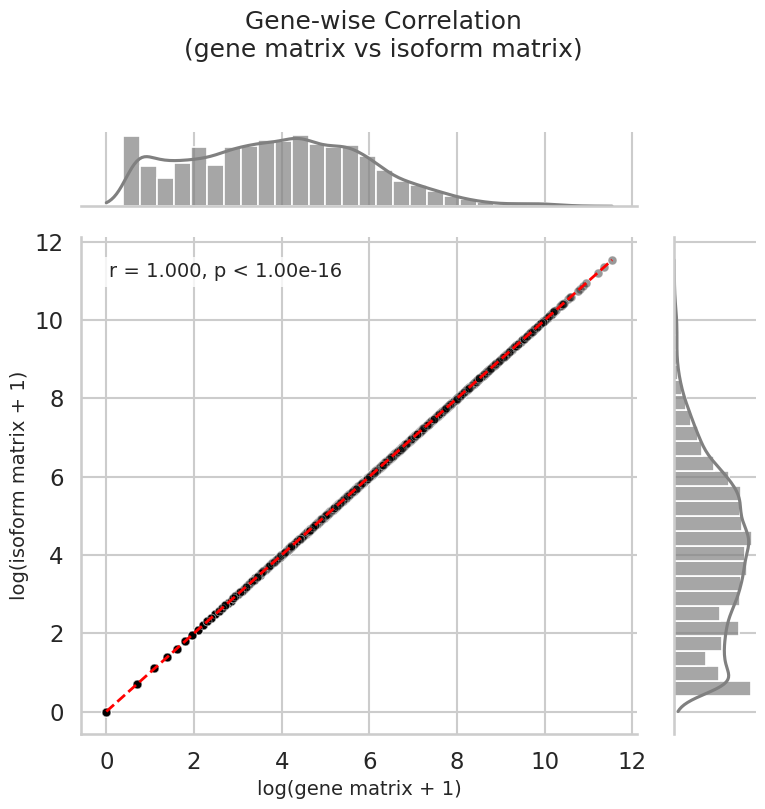

,gene matrix,gene_name,isoform matrix,log_x,log_y
0,223.0,0610009O20Rik,223.0,5.411646,5.411646
1,16.0,1110020A21Rik,16.0,2.833213,2.833213
2,1.0,1600014C23Rik,1.0,0.693147,0.693147
3,2.0,1700028P14Rik,2.0,1.098612,1.098612
4,44.0,1700086O06Rik,44.0,3.806663,3.806663
...,...,...,...,...,...
12556,547.0,mt-Nd3,547.0,6.306275,6.306275
12557,7720.0,mt-Nd4,7720.0,8.951699,8.951699
12558,2.0,mt-Nd4l,2.0,1.098612,1.098612
12559,1383.0,mt-Nd5,1383.0,7.232733,7.232733


In [87]:
gene_wise_correlation(adata_1=gene_adata, adata_2=combined_mouse_data, label_1="gene matrix", label_2 = "isoform matrix")

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import nbdev; nbdev.nbdev_export()